<a href="https://colab.research.google.com/github/iishutov/CV-Project/blob/master/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import a dataset

In [ ]:
!pip install keras-tuner -q

import os, zipfile, cv2
from cv2 import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, regularizers
import keras_tuner
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [24]:
! rm -rf sample_data
! rm -rf colored
! mkdir colored

train_dir = '/content/colored/train'
test_dir = '/content/colored/test'

train_dir_zip = '/content/drive/MyDrive/ML/my-dataset/train.zip'
test_dir_zip = '/content/drive/MyDrive/ML/my-dataset/test.zip'
# import folders from Google Drive with a dataset and unzip them.
for zip_dir, dir in zip((train_dir_zip, test_dir_zip), (train_dir, test_dir)):
  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(dir)

In [14]:
# Converting images to grayscale format.
! rm -rf grayscale
! mkdir -p grayscale/train; cd grayscale/train; mkdir empty full/; cd
! mkdir -p grayscale/test; cd grayscale/test; mkdir empty full/; cd

train_grayscale_dir = '/content/grayscale/train'
test_grayscale_dir = '/content/grayscale/test'

for colored_dir, grayscale_dir in zip((train_dir, test_dir), (train_grayscale_dir, test_grayscale_dir)):
  for container_class in 'empty', 'full':
    c_class_dir = os.path.join(colored_dir, container_class)
    g_class_dir = os.path.join(grayscale_dir, container_class)
    for filename in os.listdir(c_class_dir):
      img = cv2.imread(os.path.join(c_class_dir, filename), 0)
      cv2.imwrite(os.path.join(g_class_dir, filename), img)

train_dir = train_grayscale_dir
test_dir = test_grayscale_dir

# Preprocess the data

In [25]:
batch_size = 32
rescale = 1./255
img_height = img_width = 128

In [26]:
# Training dataset preprocessing
train_datagen = ImageDataGenerator(
    rescale=rescale,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    #brightness_range=(0.8, 1.2),
    channel_shift_range=50
)

train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42,
)

Found 630 images belonging to 2 classes.


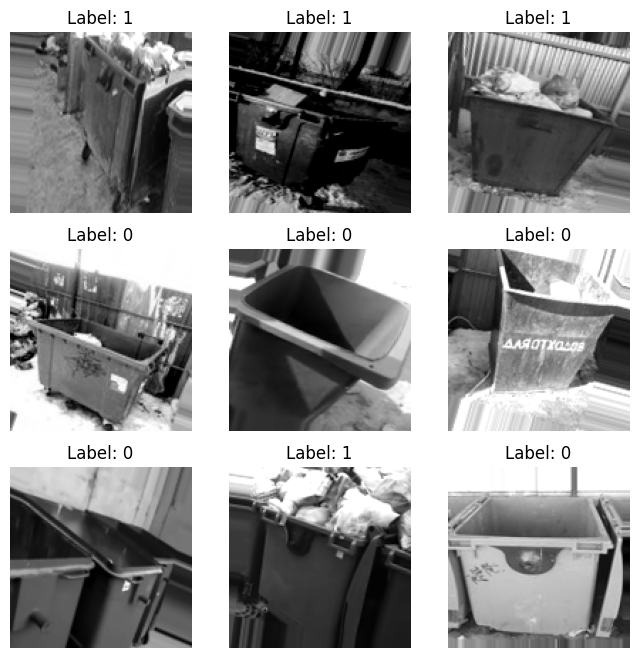

In [27]:
# Show some examples of the augmentated training dataset.
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        image, label = train_dataset.next()
        axs[i,j].imshow(image[0], cmap='gray')
        axs[i,j].set_title(f'Label: {(int)(label[0])}')
        axs[i,j].axis('off')
plt.show()

In [28]:
# Testing dataset preprocessing (normalization).
test_datagen = ImageDataGenerator(rescale=rescale)

test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 160 images belonging to 2 classes.


# Model build

In [73]:
def build_model(hp):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate=0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(rate=0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )
  return model

custom_callbacks = [tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)]

def plot_metrics(history):
  fig, (axs_loss, axs_acc) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
  for axs, metric in zip([axs_loss, axs_acc], ['loss', 'accuracy']):
    axs.set_title(f'Model {metric}')
    axs.set_ylabel(f'{metric}')
    axs.set_xlabel('epoch')
    axs.plot(history.history[f'{metric}'], label='Train')
    axs.plot(history.history[f'val_{metric}'], label='Validation')
    axs.legend(loc='lower right')
    axs.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

  fig.subplots_adjust(wspace=0.5)
  plt.show()

## Fine-tune

In [ ]:
# Hyperparameters tuning.
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=3,
    overwrite=True,
    directory="/content/tuning",
    project_name="dropout",
)
tuner.search_space_summary()

In [ ]:
tuner.search(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=custom_callbacks
    )
model = tuner.get_best_models(num_models=1)[0]

In [ ]:
tuner.results_summary()

## Train the model

Epoch 1/50
20/20 [==============================] - 33s 2s/step - loss: 0.6733 - accuracy: 0.6111 - val_loss: 0.6810 - val_accuracy: 0.5323
Epoch 2/50
20/20 [==============================] - 33s 2s/step - loss: 0.6572 - accuracy: 0.6048 - val_loss: 0.6724 - val_accuracy: 0.5430
Epoch 3/50
20/20 [==============================] - 31s 2s/step - loss: 0.6601 - accuracy: 0.6127 - val_loss: 0.6603 - val_accuracy: 0.6505
Epoch 4/50
20/20 [==============================] - 36s 2s/step - loss: 0.6434 - accuracy: 0.6206 - val_loss: 0.6439 - val_accuracy: 0.6398
Epoch 5/50
20/20 [==============================] - 38s 2s/step - loss: 0.6015 - accuracy: 0.6698 - val_loss: 0.6260 - val_accuracy: 0.6559
Epoch 6/50
20/20 [==============================] - 36s 2s/step - loss: 0.6089 - accuracy: 0.6619 - val_loss: 0.6457 - val_accuracy: 0.6720
Epoch 7/50
20/20 [==============================] - 34s 2s/step - loss: 0.5950 - accuracy: 0.6825 - val_loss: 0.6356 - val_accuracy: 0.6559
Epoch 8/50
20/20 [==

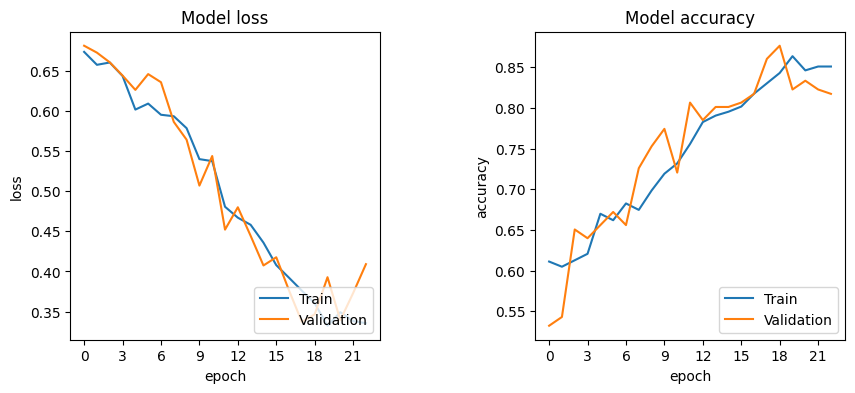

In [74]:
model = build_model(None)
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=custom_callbacks
    )
plot_metrics(history)

In [75]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 64)       

# Predict

In [77]:
def show_predictions(test_dataset):
  predictions = model.predict(test_dataset)

  idx = 0
  rng = np.random.default_rng()
  fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(11,11))

  for i in range(4):
    for j in range(4):
      image, label = test_dataset.next()
      _batch_size = label.shape[0]
      
      local_idx = (int)(_batch_size * rng.uniform())
      global_idx = (idx + local_idx) % len(predictions)

      real_class = 'full' if np.round(label[local_idx]) else 'empty'
      predicted_class = 'full' if np.round(predictions[global_idx][0]) else 'empty'

      axs[i,j].set_title(f'real: {real_class}, pred: {predicted_class}')\
        .set_color('green' if real_class == predicted_class else 'red')
      axs[i,j].imshow(image[local_idx], cmap='gray')
      axs[i,j].axis('off')

      idx += _batch_size

  plt.show()

def test(author, import_data, show_result):
  grayscale_dir = f'/content/testing/{author}/grayscale'

  if (import_data):
    zip_dir = f'/content/drive/MyDrive/ML/test_{author}.zip'
    dir = f'/content/testing/{author}'
    with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(dir)
    
    test_dir = colored_dir = f'/content/testing/{author}/test'
    for container_class in 'empty', 'full':
      c_class_dir = os.path.join(colored_dir, container_class)
      g_class_dir = os.path.join(grayscale_dir, container_class)
      for filename in os.listdir(c_class_dir):
        img = cv2.imread(os.path.join(c_class_dir, filename), 0)
        cv2.imwrite(os.path.join(g_class_dir, filename), img)

  test_dir = grayscale_dir

  test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
  )
  model.evaluate(test_dataset)
  
  if (show_result):
    show_predictions(test_dataset)

## Import a model

In [66]:
model = keras.models.load_model('/content/drive/MyDrive/ML/models/dropout225')

## Test on my own testing set

6/6 [==============================] - 2s 300ms/step


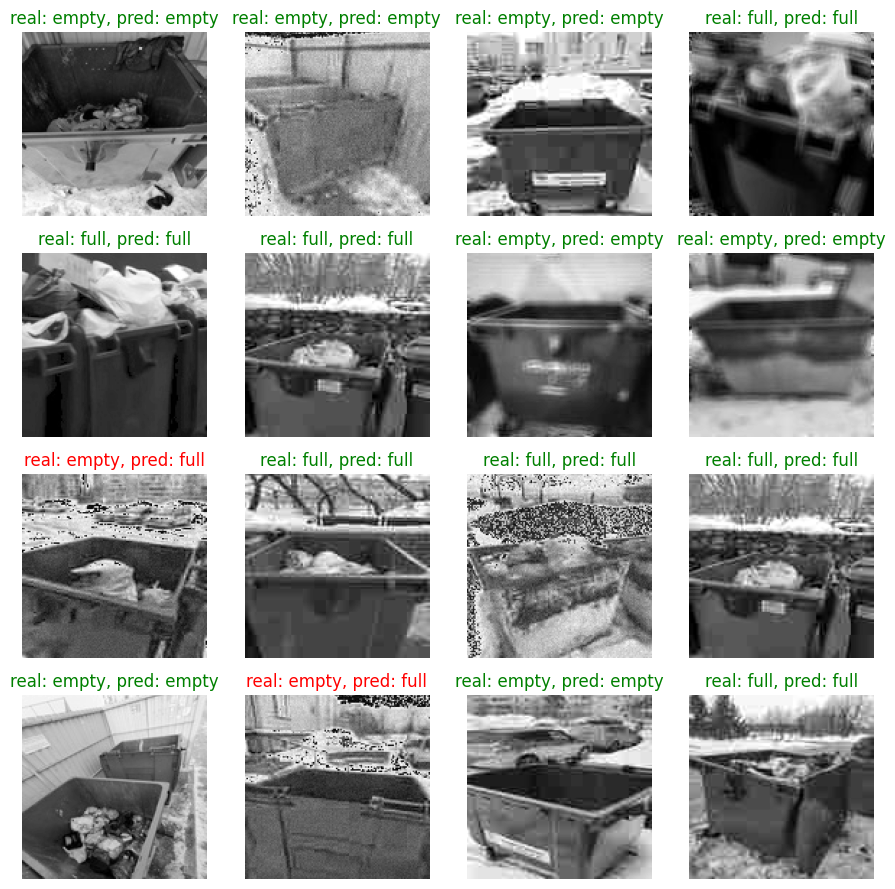

In [81]:
show_predictions(test_dataset)

## Test on other`s testing sets

Found 186 images belonging to 2 classes.
6/6 [==============================] - 2s 303ms/step


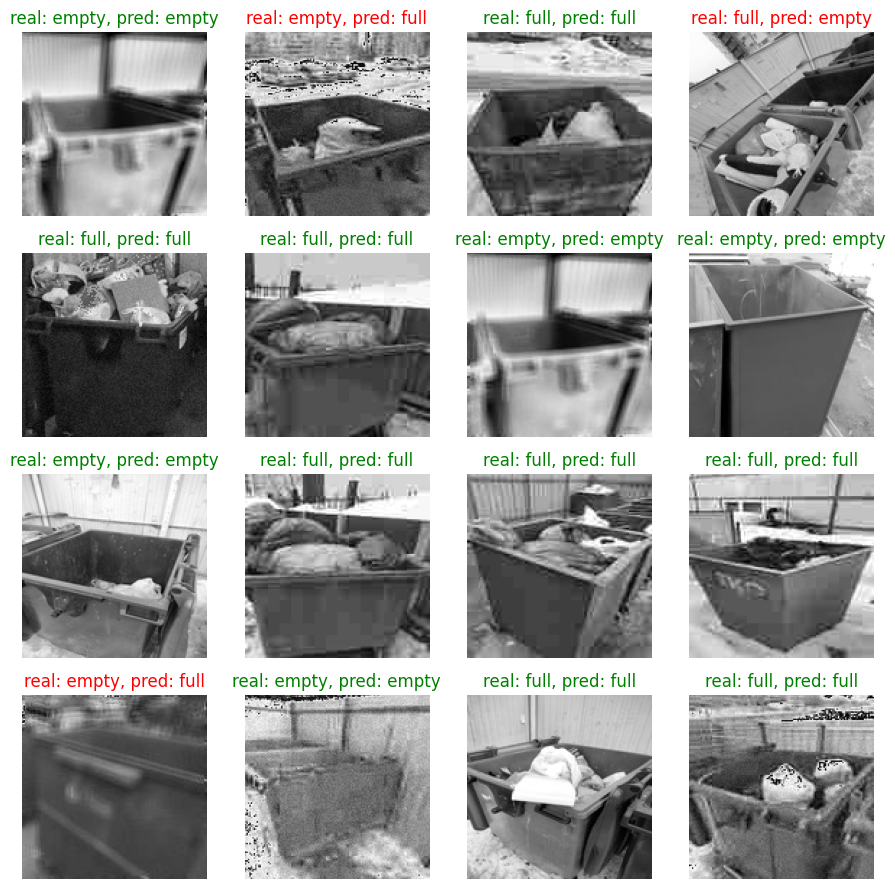

In [80]:
! rm -rf testing/Sob
! mkdir -p testing/Sob/grayscale/empty testing/Sob/grayscale/full

test('Sob', import_data=True, show_result=True)

# Save the model

In [82]:
model.save("/content/drive/MyDrive/ML/models/dropout225")